<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/INF0618_Trabalho_01_Kurosawa_Suda_Wakabayashi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inf0618 Deep Learning - Trabalho 1 - CNN**
## Integrantes do grupo:
#### - Daniel Noriaki Kurosawa
#### - Eric Uyemura Suda
#### - Fernando Shigeru Wakabayashi

In [46]:
#Importando as libs necessarias

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, optimizers, regularizers, initializers

import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

In [53]:
# Funcoes auxiliares

def fit_train_eval(model, x_train, y_train_oh, y_val, epochs, batch_size, class_weight, validation_data):
  print("Treinando o Modelo \n\n")
  history = model.fit(x_train, 
                      y_train_oh, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      class_weight=class_weight,
                      validation_data=validation_data,
                      use_multiprocessing=True)
  
  # Faz as predições para o conjunto de teste
  print("\nFazendo Predicoes da Validacao\n")
  predictions = model.predict(x_val)
  #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.

  #Matriz de confusão
  cm = confusion_matrix(np.argmax(predictions, axis=1), y_val)
  plt.figure(figsize = (11,9))
  ax1=plt.axes()
  ax1.set_title("Matriz de Confusao")
  sns.set(font_scale=0.9)
  sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')

  # Matriz de confusão normalizada
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cmn) / num_classes
  print("\n\nAcurácia balanceada:", balanced_acc, "\n")

  plt.figure(figsize = (11,9))
  ax = plt.axes()
  ax.set_title("Matriz de Confusao Normalizada")
  sns.set(font_scale=0.9)
  sns.heatmap(cmn, annot=True, fmt='.1%', cmap='viridis')

  # Curva de Vies Varianca
  return history

In [15]:
#Importando Dataset do trabalho

from tensorflow.keras.datasets import cifar10
(x_trainval, y_trainval), (x_test, y_test) = cifar10.load_data()

In [16]:
#Cada imagem tem o tamanho de 32x32x3

print("Tamanho treino {}".format(x_trainval.shape), "\t", "Tamanho teste {}".format(x_test.shape))

Tamanho treino (50000, 32, 32, 3) 	 Tamanho teste (10000, 32, 32, 3)


In [17]:
#Dataset ja esta balanceado com 5k amostras para cada classe de imagem

unique, counts = np.unique(y_trainval, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

Treino --->  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000} 



## 1) Separando Dataset em Treino e Validacao

In [18]:
#Separando o dataset em treino(80%) e validacao(20%)

#Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainval.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

#Divide os dados
x_val, y_val = x_trainval[valIdx], y_trainval[valIdx]
x_train, y_train = x_trainval[trainIdx], y_trainval[trainIdx]

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)

Formato das imagens de treinamento (40000, 32, 32, 3)
Formato dos rótulos de treinamento (40000, 1)

Formato das imagens de validação (10000, 32, 32, 3)
Formato dos rótulos de validação (10000, 1)


In [19]:
# Escalando dados de para um intervalo de 0-1

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [22]:
# One hot encoding das classes de saida

num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)
print("Exemplo: ")
print("Classe Imagem: ", y_train[0], "\tOne Hot: ", y_train_oh[0])

(40000, 32, 32, 3) (40000, 10)
Exemplo: 
Classe Imagem:  [4] 	One Hot:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [21]:
num_classes

10

## 2) Criando Rede Neural Baseline

In [23]:
# Rede Neural Vanilla

model_baseline = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_baseline.add(layers.Conv2D(10, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline.add(layers.Dense(10))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                25610     
Total params: 25,890
Trainable params: 25,890
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/32
800/800 [==============================] - 20s 25ms/step - loss: 1.5514 - accuracy: 0.4611 - val_loss: 1.6057 - val_accuracy: 0.4493
Epoch 2/32
800/800 [==============================] - 20s 26ms/step - loss: 1.5354 - accuracy: 0.4659 - val_loss: 1.7342 - val_accuracy: 0.4073
Epoch 3/32
800/800 [==============================] - 20s 25ms/step - loss: 1.5592 - accuracy: 0.4576 - val_loss: 1.6676 - val_accuracy: 0.4322
Epoch 4/32
800/800 [==============================] - 20s 25ms/step - loss: 1.5476 - accuracy: 0.4606 - val_loss: 1.6109 - val_accuracy: 0.4506
Epoch 5/32
800/800 [==============================] - 20s 25ms/step - loss: 1.5518 - accuracy: 0.4590 - val_loss: 1.6152 - val_accuracy: 0.4426
Epoch 6/32
800/800 [==============================] - 20s 26ms/step - loss: 1.5472 - accuracy: 0.4612 - val_loss: 1.6366 - val_accuracy: 0.4472
Epoch 7/32
800/800 [==============================] - 21s 26ms/step - loss: 1.5323 - accuracy: 0.4651 - val_loss: 

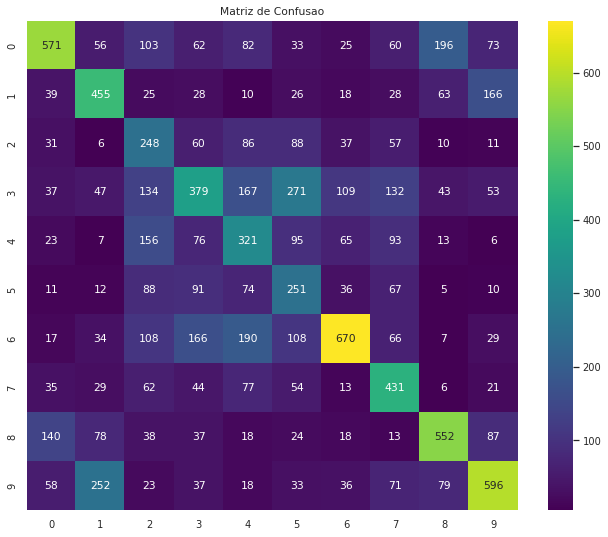

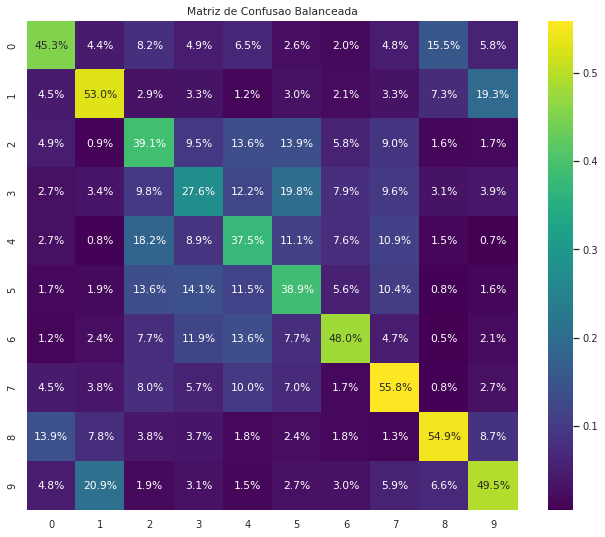

In [26]:
history_relu = fit_train_eval(model_baseline, x_train, y_train_oh, y_val, epochs=32, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

## 3) Testando Diferentes Funcoes de Ativacao Para o Mesmo Modelo Baseline

[Referencia de Funcoes de Ativacao](https://keras.io/api/layers/activations/)



In [27]:
# Modelo Vanilla com Funcao de Ativacao Sigmoide

model_baseline_sig = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_sig.add(layers.Conv2D(10, 3, padding='same', activation='sigmoid', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_sig.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_sig.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_sig.add(layers.Dense(10))

model_baseline_sig.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_sig.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                25610     
Total params: 25,890
Trainable params: 25,890
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/50
1250/1250 [==============================] - 26s 21ms/step - loss: 2.0782 - accuracy: 0.3169 - val_loss: 1.7705 - val_accuracy: 0.3864
Epoch 2/50
1250/1250 [==============================] - 23s 19ms/step - loss: 1.6850 - accuracy: 0.4121 - val_loss: 1.6197 - val_accuracy: 0.4257
Epoch 3/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5662 - accuracy: 0.4521 - val_loss: 1.5894 - val_accuracy: 0.4449
Epoch 4/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4973 - accuracy: 0.4805 - val_loss: 1.5705 - val_accuracy: 0.4616
Epoch 5/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4218 - accuracy: 0.5069 - val_loss: 1.4976 - val_accuracy: 0.4932
Epoch 6/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.3780 - accuracy: 0.5265 - val_loss: 1.4165 - val_accuracy: 0.5125
Epoch 7/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.3412 - accuracy: 0.537

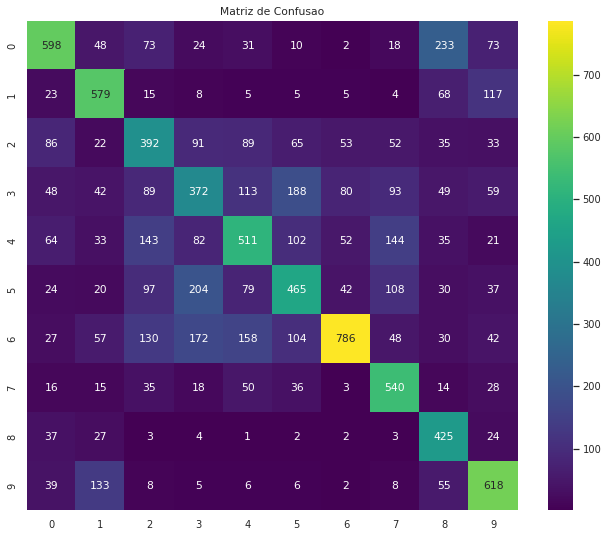

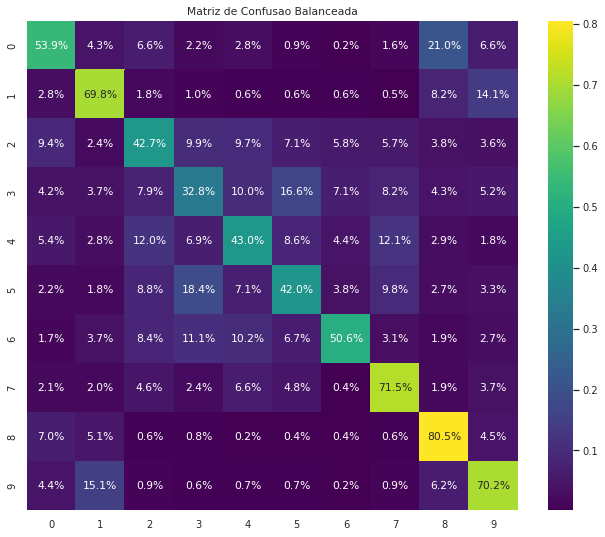

In [28]:
history_sig = fit_train_eval(model_baseline_sig, x_train, y_train_oh, y_val, epochs=50, batch_size=32, class_weight=None, validation_data=(x_val, y_val_oh))

In [29]:
# Modelo Vanilla com Funcao de Ativacao Tangente Hiperbolica

model_baseline_hip = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_hip.add(layers.Conv2D(10, 3, padding='same', activation='tanh', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_hip.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_hip.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_hip.add(layers.Dense(10))

model_baseline_hip.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_hip.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                25610     
Total params: 25,890
Trainable params: 25,890
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/50
1250/1250 [==============================] - 25s 20ms/step - loss: 1.7450 - accuracy: 0.4038 - val_loss: 1.5282 - val_accuracy: 0.4717
Epoch 2/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.5714 - accuracy: 0.4805 - val_loss: 1.6827 - val_accuracy: 0.4515
Epoch 3/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4896 - accuracy: 0.5087 - val_loss: 1.5737 - val_accuracy: 0.4836
Epoch 4/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.4505 - accuracy: 0.5232 - val_loss: 1.5529 - val_accuracy: 0.4886
Epoch 5/50
1250/1250 [==============================] - 25s 20ms/step - loss: 1.4206 - accuracy: 0.5341 - val_loss: 1.8554 - val_accuracy: 0.4370
Epoch 6/50
1250/1250 [==============================] - 24s 20ms/step - loss: 1.4181 - accuracy: 0.5376 - val_loss: 1.4836 - val_accuracy: 0.5066
Epoch 7/50
1250/1250 [==============================] - 25s 20ms/step - loss: 1.3853 - accuracy: 0.550

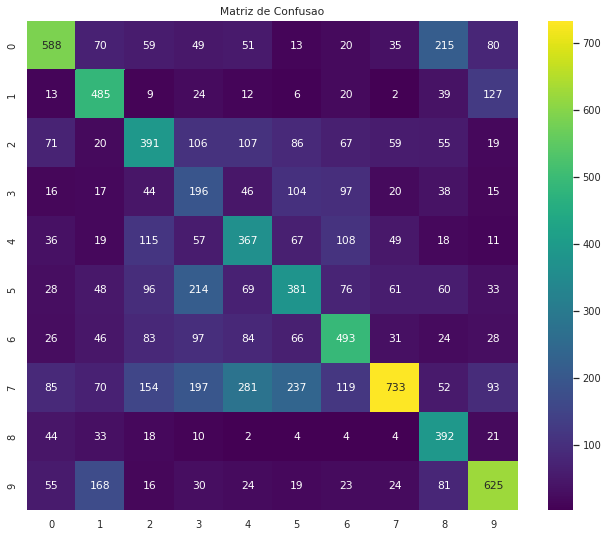

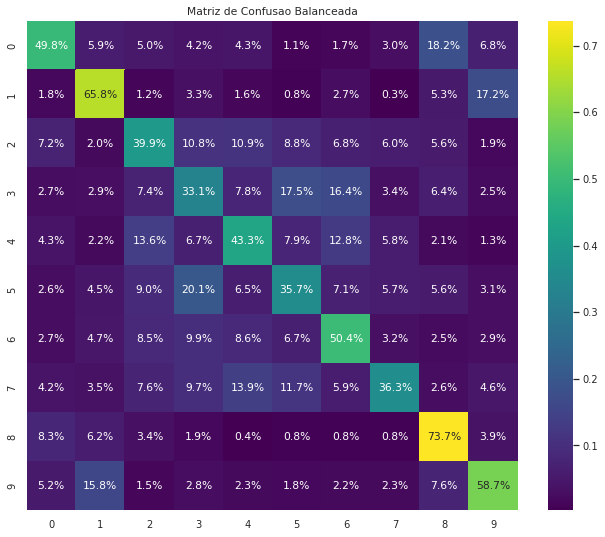

In [30]:
history_hip = fit_train_eval(model_baseline_hip, x_train, y_train_oh, y_val, epochs=50, batch_size=32, class_weight=None, validation_data=(x_val, y_val_oh))

In [31]:
# Modelo Vanilla com Funcao de Ativacao SeLu

model_baseline_selu = tf.keras.Sequential()
#Camada convolucional com 10 filtros de tamanho 3x3 e ativação Sigmoide
model_baseline_selu.add(layers.Conv2D(10, 3, padding='same', activation='selu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline_selu.add(layers.MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_selu.add(layers.Flatten())
#Densa com 10 nós de saída
model_baseline_selu.add(layers.Dense(10))

model_baseline_selu.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_baseline_selu.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                25610     
Total params: 25,890
Trainable params: 25,890
Non-trainable params: 0
_________________________________________________________________


Treinando o Modelo 


Epoch 1/32
800/800 [==============================] - 28s 35ms/step - loss: 1.7462 - accuracy: 0.4036 - val_loss: 1.7012 - val_accuracy: 0.4153
Epoch 2/32
800/800 [==============================] - 24s 30ms/step - loss: 1.5685 - accuracy: 0.4730 - val_loss: 1.5589 - val_accuracy: 0.4770
Epoch 3/32
800/800 [==============================] - 24s 30ms/step - loss: 1.4465 - accuracy: 0.5171 - val_loss: 1.5842 - val_accuracy: 0.4860
Epoch 4/32
800/800 [==============================] - 24s 30ms/step - loss: 1.4427 - accuracy: 0.5241 - val_loss: 1.4464 - val_accuracy: 0.5173
Epoch 5/32
800/800 [==============================] - 24s 31ms/step - loss: 1.4196 - accuracy: 0.5339 - val_loss: 1.7063 - val_accuracy: 0.4662
Epoch 6/32
800/800 [==============================] - 24s 30ms/step - loss: 1.3646 - accuracy: 0.5497 - val_loss: 1.5234 - val_accuracy: 0.5021
Epoch 7/32
800/800 [==============================] - 24s 30ms/step - loss: 1.3753 - accuracy: 0.5491 - val_loss: 

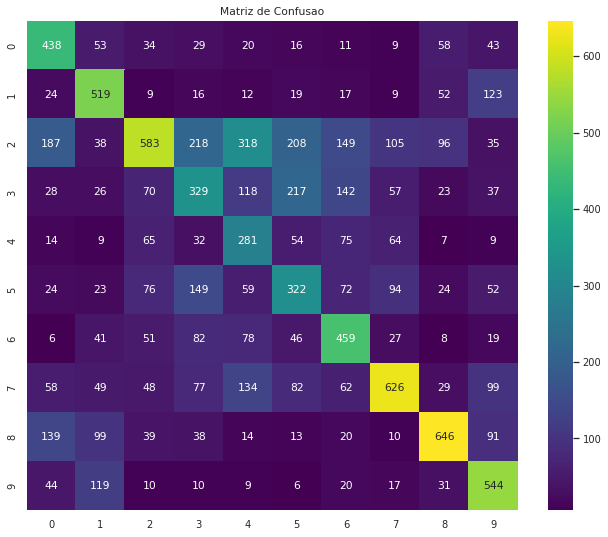

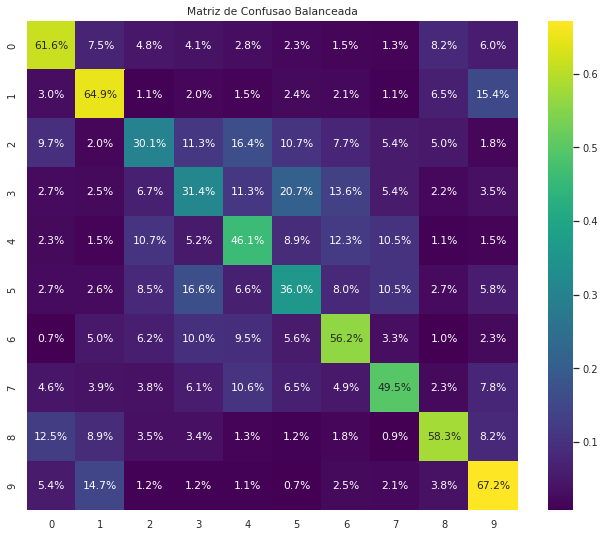

In [32]:
history_selu = fit_train_eval(model_baseline_selu, x_train, y_train_oh, y_val, epochs=32, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

## 4) Variacao da quantidade de camadas de convolucao e pooling

In [35]:
# Rede Neural com mais camadas de convolucao e pooling

model_comp = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_comp.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_comp.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp.add(layers.Flatten())

#Densa com 10 nós de saída
model_comp.add(layers.Dense(10))

model_comp.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                40970     
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
__________________________________________________

Treinando o Modelo 


Epoch 1/32
800/800 [==============================] - 72s 89ms/step - loss: 1.7755 - accuracy: 0.3512 - val_loss: 1.5459 - val_accuracy: 0.4465
Epoch 2/32
800/800 [==============================] - 71s 89ms/step - loss: 1.5210 - accuracy: 0.4570 - val_loss: 1.4801 - val_accuracy: 0.4724
Epoch 3/32
800/800 [==============================] - 71s 89ms/step - loss: 1.4645 - accuracy: 0.4784 - val_loss: 1.4770 - val_accuracy: 0.4771
Epoch 4/32
800/800 [==============================] - 72s 90ms/step - loss: 1.4251 - accuracy: 0.4934 - val_loss: 1.4234 - val_accuracy: 0.4928
Epoch 5/32
800/800 [==============================] - 72s 90ms/step - loss: 1.4148 - accuracy: 0.4963 - val_loss: 1.5824 - val_accuracy: 0.4444
Epoch 6/32
800/800 [==============================] - 72s 90ms/step - loss: 1.3997 - accuracy: 0.5048 - val_loss: 1.4381 - val_accuracy: 0.4808
Epoch 7/32
800/800 [==============================] - 73s 91ms/step - loss: 1.3852 - accuracy: 0.5094 - val_loss: 

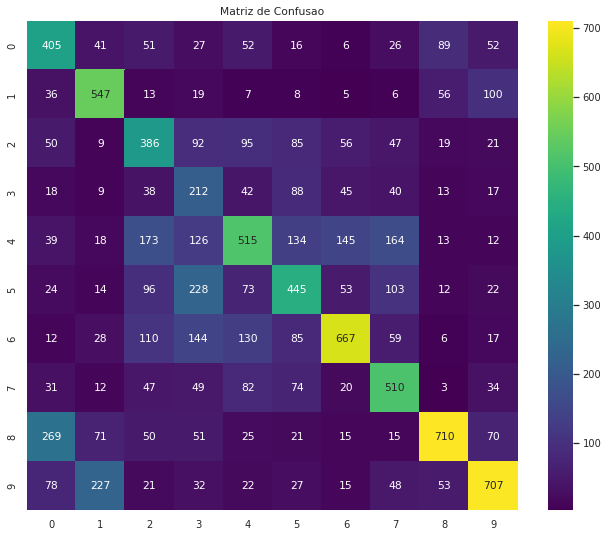

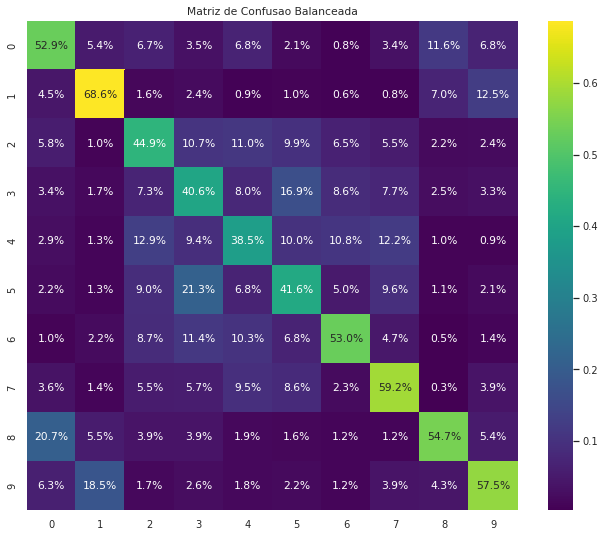

In [36]:
history_comp = fit_train_eval(model_comp, x_train, y_train_oh, y_val, epochs=32, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

In [37]:
# Rede Neural com mais camadas de convolucao e pooling

model_comp2 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp2.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_comp2.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_comp2.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp2.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_comp2.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp2.add(layers.Flatten())

#Densa com 10 nós de saída
model_comp2.add(layers.Dense(10))

model_comp2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 256)         147712    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)             

In [41]:
history_comp2 = fit_train_eval(model_comp2, x_train, y_train_oh, y_val, epochs=20, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

Treinando o Modelo 


Epoch 1/20
800/800 [==============================] - 143s 179ms/step - loss: 2.3037 - accuracy: 0.1009 - val_loss: 2.3036 - val_accuracy: 0.0983
Epoch 2/20
800/800 [==============================] - 142s 178ms/step - loss: 2.3036 - accuracy: 0.1027 - val_loss: 2.3057 - val_accuracy: 0.0976
Epoch 3/20
800/800 [==============================] - 144s 180ms/step - loss: 2.3039 - accuracy: 0.0987 - val_loss: 2.3033 - val_accuracy: 0.1052
Epoch 4/20
143/800 [====>.........................] - ETA: 1:52 - loss: 2.3041 - accuracy: 0.0993

KeyboardInterrupt: ignored

## 5) Teste de metodologias de inicializacao e regularizacao

In [42]:
# Rede Neural com mais camadas de convolucao e pooling

model_comp_v2 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v2.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal'))
#Max pooling de tamanho 2x2
model_comp_v2.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v2.add(layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='glorot_normal'))
#Max pooling de tamanho 2x2
model_comp_v2.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp_v2.add(layers.Flatten())

#Densa com 10 nós de saída
model_comp_v2.add(layers.Dense(10))

model_comp_v2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp_v2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                40970     
Total params: 60,362
Trainable params: 60,362
Non-trainable params: 0
_________________________________________________

Treinando o Modelo 


Epoch 1/20
800/800 [==============================] - 74s 92ms/step - loss: 1.6128 - accuracy: 0.4257 - val_loss: 1.4428 - val_accuracy: 0.4927
Epoch 2/20
800/800 [==============================] - 66s 82ms/step - loss: 1.3600 - accuracy: 0.5221 - val_loss: 1.3038 - val_accuracy: 0.5424
Epoch 3/20
800/800 [==============================] - 65s 81ms/step - loss: 1.3051 - accuracy: 0.5424 - val_loss: 1.3180 - val_accuracy: 0.5436
Epoch 4/20
800/800 [==============================] - 66s 83ms/step - loss: 1.2788 - accuracy: 0.5540 - val_loss: 1.3396 - val_accuracy: 0.5329
Epoch 5/20
800/800 [==============================] - 66s 82ms/step - loss: 1.2581 - accuracy: 0.5609 - val_loss: 1.2838 - val_accuracy: 0.5569
Epoch 6/20
800/800 [==============================] - 66s 83ms/step - loss: 1.2499 - accuracy: 0.5634 - val_loss: 1.3530 - val_accuracy: 0.5306
Epoch 7/20
800/800 [==============================] - 67s 83ms/step - loss: 1.2358 - accuracy: 0.5684 - val_loss: 

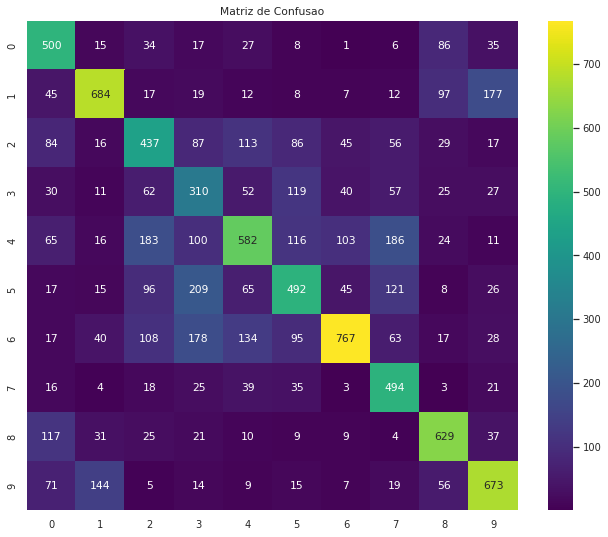

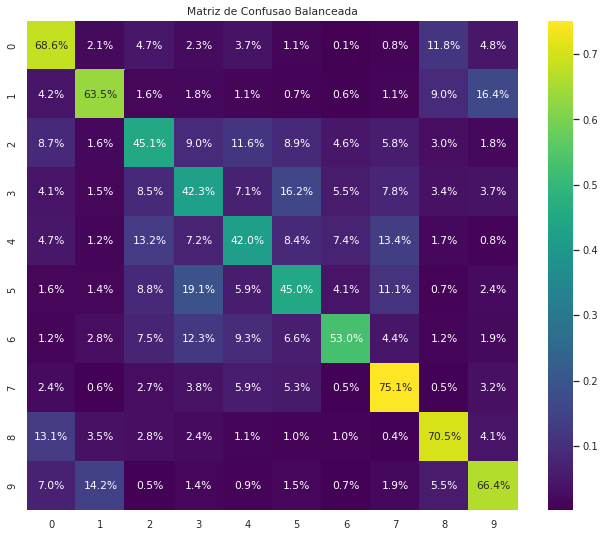

In [43]:
history_comp_v2 = fit_train_eval(model_comp_v2, x_train, y_train_oh, y_val, epochs=20, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

In [51]:
# Rede Neural com mais camadas de convolucao e pooling, initializacao, regularizacao e normalizacao

model_comp_v3 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v3.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_comp_v3.add(layers.BatchNormalization())
model_comp_v3.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v3.add(layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_comp_v3.add(layers.BatchNormalization())
model_comp_v3.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp_v3.add(layers.Flatten())

#Densa com 10 nós de saída
model_comp_v3.add(layers.Dense(10))

model_comp_v3.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp_v3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 4096)            

Treinando o Modelo 


Epoch 1/20
800/800 [==============================] - 91s 114ms/step - loss: 1.4876 - accuracy: 0.5181 - val_loss: 1.9524 - val_accuracy: 0.3974
Epoch 2/20
800/800 [==============================] - 104s 130ms/step - loss: 1.3867 - accuracy: 0.5581 - val_loss: 1.9030 - val_accuracy: 0.4151
Epoch 3/20
800/800 [==============================] - 104s 129ms/step - loss: 1.3300 - accuracy: 0.5819 - val_loss: 1.7291 - val_accuracy: 0.4592
Epoch 4/20
800/800 [==============================] - 103s 128ms/step - loss: 1.3191 - accuracy: 0.5853 - val_loss: 1.6235 - val_accuracy: 0.4961
Epoch 5/20
800/800 [==============================] - 102s 128ms/step - loss: 1.3020 - accuracy: 0.5914 - val_loss: 1.4427 - val_accuracy: 0.5372
Epoch 6/20
800/800 [==============================] - 101s 127ms/step - loss: 1.3007 - accuracy: 0.5900 - val_loss: 1.6707 - val_accuracy: 0.5039
Epoch 7/20
800/800 [==============================] - 101s 127ms/step - loss: 1.2861 - accuracy: 0.5964

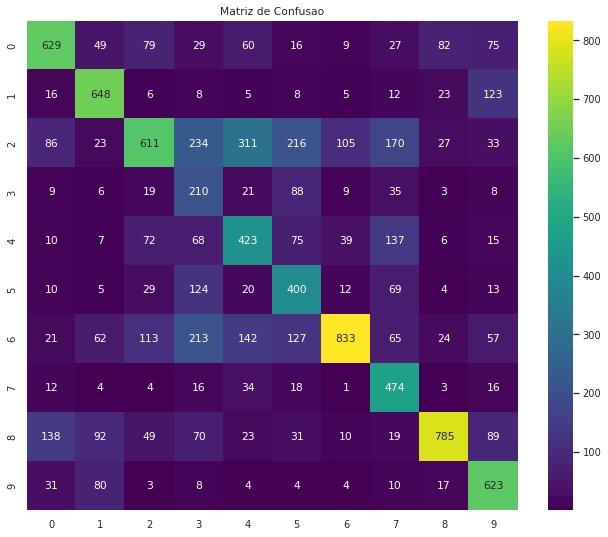

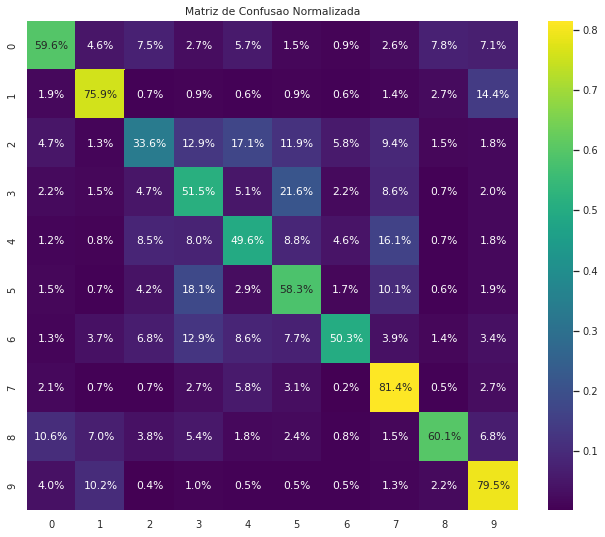

In [54]:
history_comp_v3 = fit_train_eval(model_comp_v3, x_train, y_train_oh, y_val, epochs=20, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

In [61]:
# Rede Neural com mais camadas de convolucao e pooling, initializacao, regularizacao e normalizacao

model_comp_v4 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v4.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_comp_v4.add(layers.BatchNormalization())
model_comp_v4.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v4.add(layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(0.01)))
model_comp_v4.add(layers.BatchNormalization())
model_comp_v4.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp_v4.add(layers.Flatten())

#Densa com 10 nós de saída
model_comp_v4.add(layers.Dense(10))

model_comp_v4.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp_v4.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)            

Treinando o Modelo 


Epoch 1/20
800/800 [==============================] - 91s 113ms/step - loss: 3.0690 - accuracy: 0.4288 - val_loss: 2.3583 - val_accuracy: 0.4023
Epoch 2/20
800/800 [==============================] - 95s 119ms/step - loss: 1.8031 - accuracy: 0.5276 - val_loss: 2.8341 - val_accuracy: 0.3258
Epoch 3/20
800/800 [==============================] - 93s 116ms/step - loss: 1.7687 - accuracy: 0.5440 - val_loss: 1.9943 - val_accuracy: 0.4656
Epoch 4/20
800/800 [==============================] - 93s 116ms/step - loss: 1.7427 - accuracy: 0.5566 - val_loss: 2.1833 - val_accuracy: 0.4247
Epoch 5/20
800/800 [==============================] - 92s 115ms/step - loss: 1.7060 - accuracy: 0.5622 - val_loss: 1.7978 - val_accuracy: 0.5259
Epoch 6/20
800/800 [==============================] - 93s 117ms/step - loss: 1.6997 - accuracy: 0.5640 - val_loss: 2.0455 - val_accuracy: 0.4447
Epoch 7/20
800/800 [==============================] - 94s 118ms/step - loss: 1.6902 - accuracy: 0.5677 - val

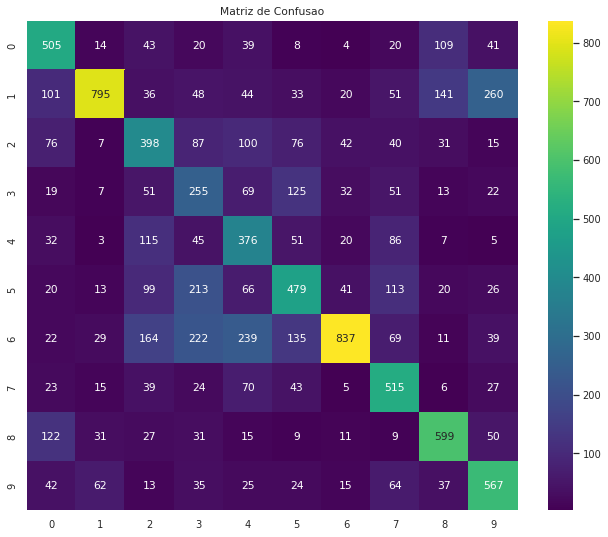

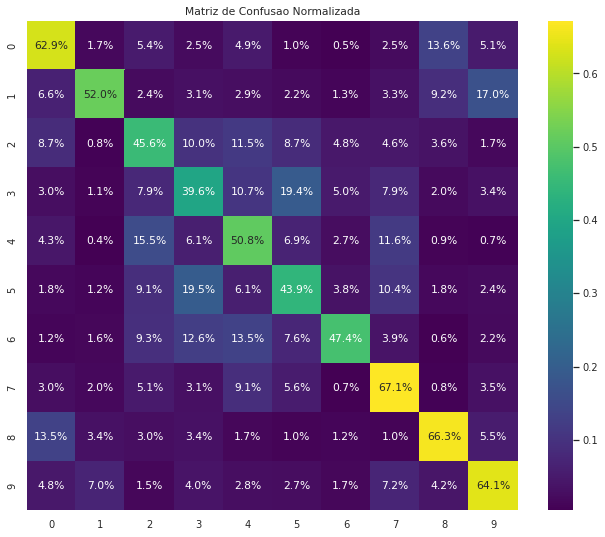

In [62]:
history_comp_v4 = fit_train_eval(model_comp_v4, x_train, y_train_oh, y_val, epochs=20, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))

In [65]:
# Rede Neural com mais camadas de convolucao e pooling, initializacao, regularizacao e normalizacao

model_comp_v5 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v5.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_comp_v5.add(layers.BatchNormalization())
model_comp_v5.add(layers.MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_comp_v5.add(layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_comp_v5.add(layers.BatchNormalization())
model_comp_v5.add(layers.MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_comp_v5.add(layers.Flatten())

model_comp_v5.add(layers.Dropout(0.2))

#Densa com 10 nós de saída
model_comp_v5.add(layers.Dense(10))

model_comp_v5.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_comp_v5.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4096)            

Treinando o Modelo 


Epoch 1/20
800/800 [==============================] - 95s 118ms/step - loss: 2.2649 - accuracy: 0.4470 - val_loss: 1.5908 - val_accuracy: 0.4942
Epoch 2/20
800/800 [==============================] - 102s 128ms/step - loss: 1.4883 - accuracy: 0.5336 - val_loss: 1.9049 - val_accuracy: 0.4173
Epoch 3/20
800/800 [==============================] - 100s 125ms/step - loss: 1.4424 - accuracy: 0.5519 - val_loss: 1.5302 - val_accuracy: 0.5186
Epoch 4/20
800/800 [==============================] - 100s 125ms/step - loss: 1.4238 - accuracy: 0.5631 - val_loss: 2.0945 - val_accuracy: 0.3655
Epoch 5/20
800/800 [==============================] - 99s 124ms/step - loss: 1.4190 - accuracy: 0.5617 - val_loss: 1.8069 - val_accuracy: 0.4494
Epoch 6/20
800/800 [==============================] - 99s 123ms/step - loss: 1.4089 - accuracy: 0.5660 - val_loss: 1.5996 - val_accuracy: 0.5246
Epoch 7/20
800/800 [==============================] - 100s 125ms/step - loss: 1.3883 - accuracy: 0.5701 -

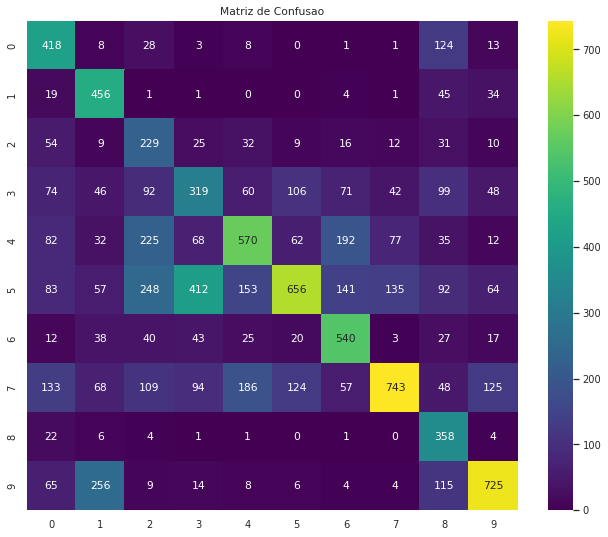

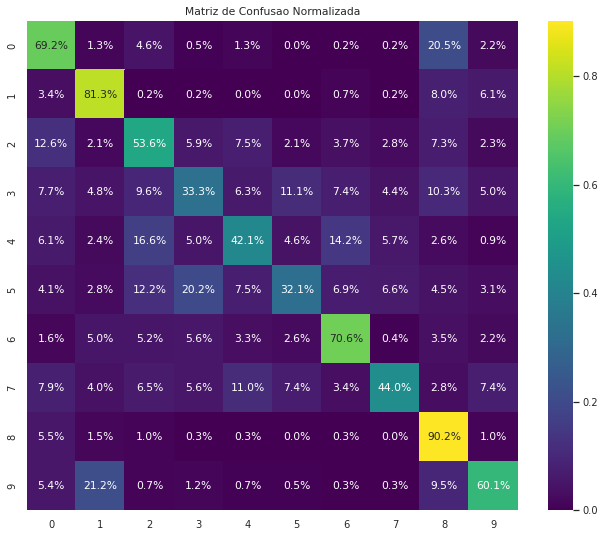

In [66]:
history_comp_v5 = fit_train_eval(model_comp_v5, x_train, y_train_oh, y_val, epochs=20, batch_size=50, class_weight=None, validation_data=(x_val, y_val_oh))